***Data loading and preliminary analysis***

In [1]:
#First, we want to get all of our data instances and classes to use. I will use PIL library to load the images because I have used it before and it is simple.
import numpy as np
from PIL import Image
import os

#local filepath to the dataset (just a folder with a bunch of images)
dataset_filepath = "Dataset"

#Create container for dataset features (pixels) and dataset labels (rock type)
dataset_features = []
dataset_labels = []


#iteratee through each image and add each image isntance into an array (and convert the result to a numpy array) for features
#Also get the Rocktype and add it to the labels container
for image_name in os.listdir(dataset_filepath):
    image_filepath = os.path.join(dataset_filepath, image_name)
    if image_filepath[-3:] == "jpg":

        #label (rocktype) and features (pixels). the First charachter is the image class
        image_features = np.array(Image.open(image_filepath).convert('L'))
        image_label = image_name[0].upper()

        #add to respective container
        dataset_features.append(image_features)
        dataset_labels.append(image_label)

#now convert each container to numpy arrays (this will help later on when we are doiong a lot data manipulation and calculations)
dataset_features = np.array(dataset_features)
dataset_labels = np.array(dataset_labels)

rock_type_integer = []
for rock_type in dataset_labels:
    if rock_type == "I":
        rock_type_integer.append(0)
    elif rock_type == "M":
        rock_type_integer.append(1)
    elif rock_type == "S":
        rock_type_integer.append(2)

In [2]:
#Now I want to do a little bit of visualization just so we understand the dataset we are working at

#First I want to see if all the images are the same size. If they are not, I am goiong to resize them all. Image check will be zero if all imagea re the same size
image_size = dataset_features[0].shape
image_check = sum([(image.shape != image_size) for image in dataset_features])

#print results
print(f"All Images Have Same Size: {image_check == 0}")

print(f"\nTotal Dataset Instances: {len(dataset_labels)}")
print(f"Individual Image Shape: {image_size}")

#Yay! They are all the same shape :)

All Images Have Same Size: True

Total Dataset Instances: 360
Individual Image Shape: (800, 800)


Total Classes: 3


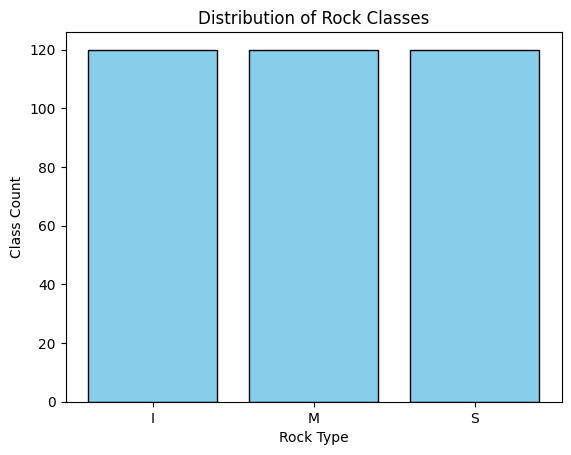

In [3]:
#And now also just a little information about our labels

#First I want to see how many labels we have (should be 3 classes), and I also want to see how amyn isntances we have of each class and plot its histogram. 
#This could be usefew for if we accidentally train or test on disporportionate class instances and just to generally know
# Create a histogram of the labels
import matplotlib.pyplot as plt

classes, classes_counts = np.unique(dataset_labels, return_counts=True)

#Plot the histogram
plt.bar(classes, classes_counts, color='skyblue', edgecolor='black')

plt.xlabel('Rock Type')
plt.ylabel('Class Count')
plt.title('Distribution of Rock Classes')


print(f"Total Classes: {len(classes)}")

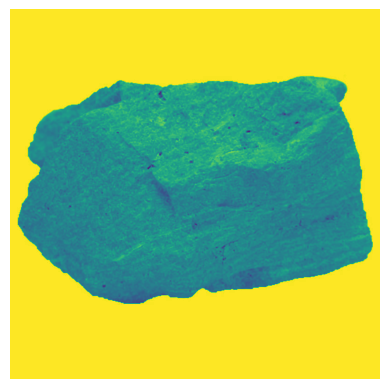

In [4]:
#Just some auxillary code to visualize the images from the dataset_features 

def display_image(image_array):
    plt.imshow(image_array)
    plt.axis('off')  
    plt.show()

display_image(dataset_features[140])

In [5]:
#For using PCA or any other algorithm, we would need the data to be in n*m shape where n is the number of instances
# i.e. 360 in this case, and m is the number of features which is 1920000 (Damnnn!) in this case.
# Following code converts our data into these required dimensions:

imageog = np.array([rock_pixels.flatten() for rock_pixels in dataset_features])
print(imageog.shape)

(360, 640000)


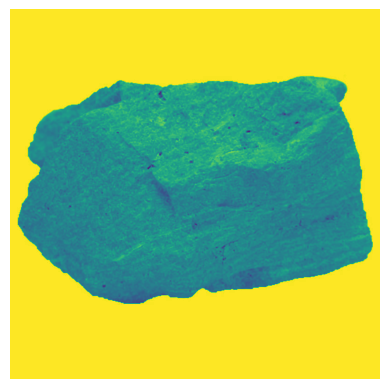

In [6]:
#Auxillary function: Just checking if we can retrive the iamge from this reshaped data
def reshape_and_display(flat_image_array):
    image = flat_image_array.reshape(800, 800)
    display_image(image)

reshape_and_display(imageog[140])

***Question 1***

In [7]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(imageog)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.90) + 1  
print(d)

158


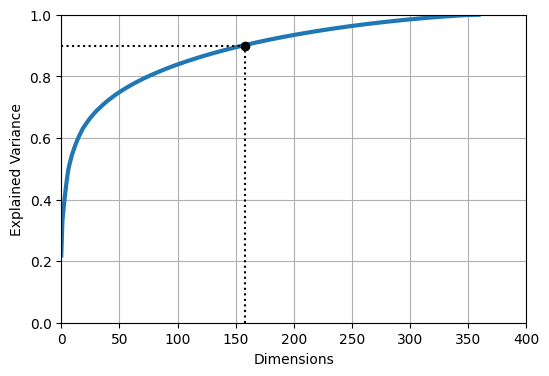

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.90], "k:")
plt.plot([0, d], [0.90, 0.90], "k:")
plt.plot(d, 0.90, "ko")
plt.grid(True)

As we see from above, we need 158 components to keep more than 90% of the varience.

***Question 2***

In [9]:
pca = PCA(n_components=158)
image_downsized = pca.fit_transform(imageog)
print(image_downsized.shape)

(360, 158)


In [10]:
image_recovered = pca.inverse_transform(image_downsized)
print(image_recovered.shape)

(360, 640000)


Printing image indices:  [206  49 142 229  42 140 119 352 238  28]


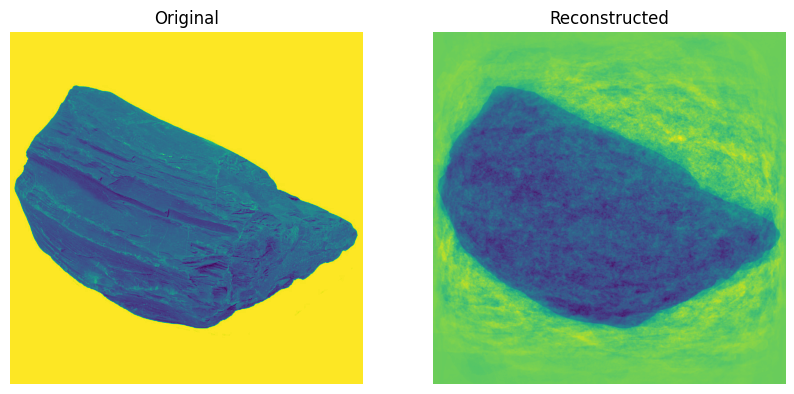

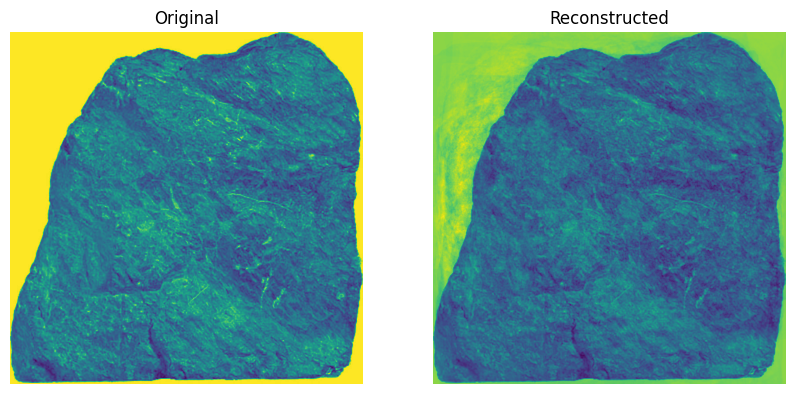

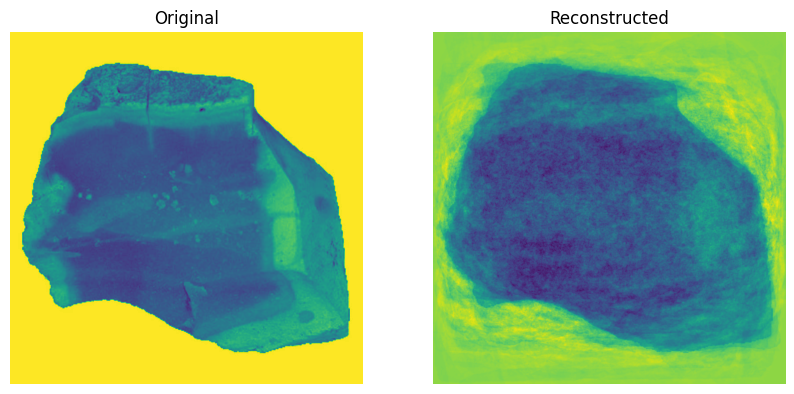

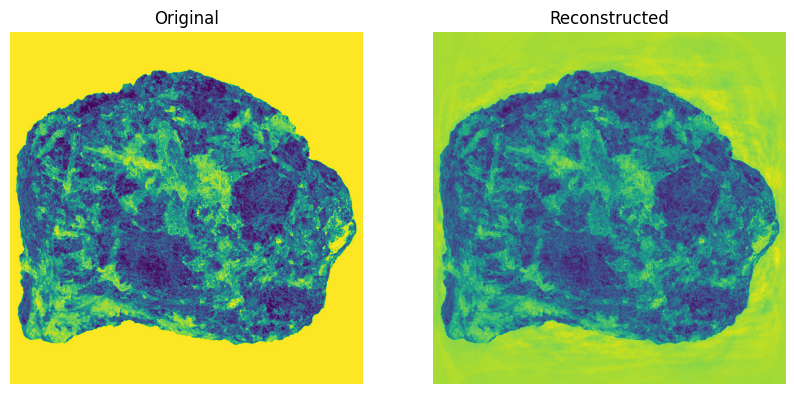

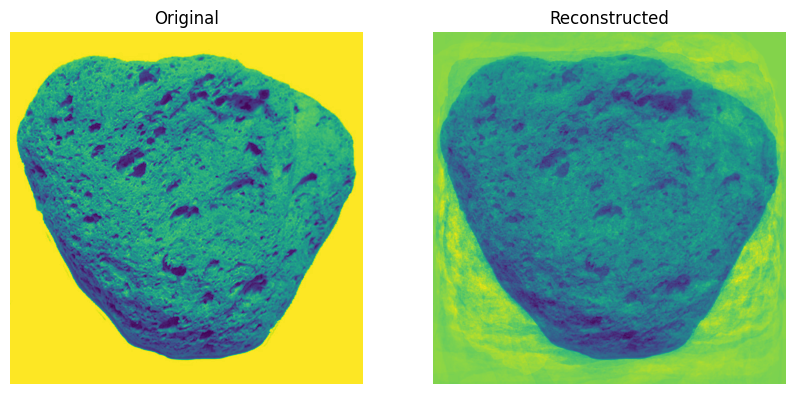

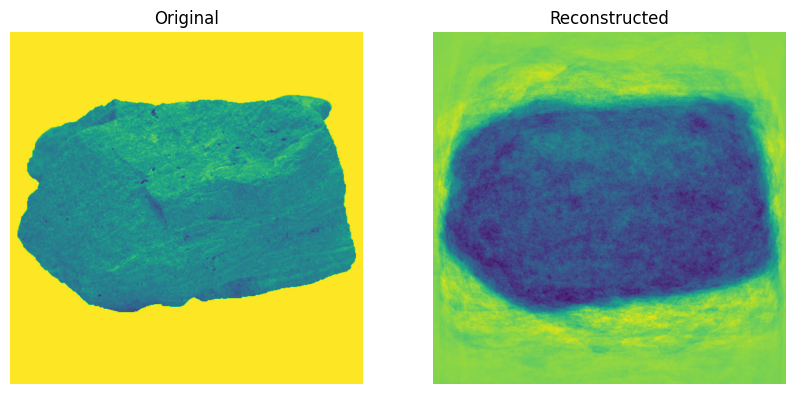

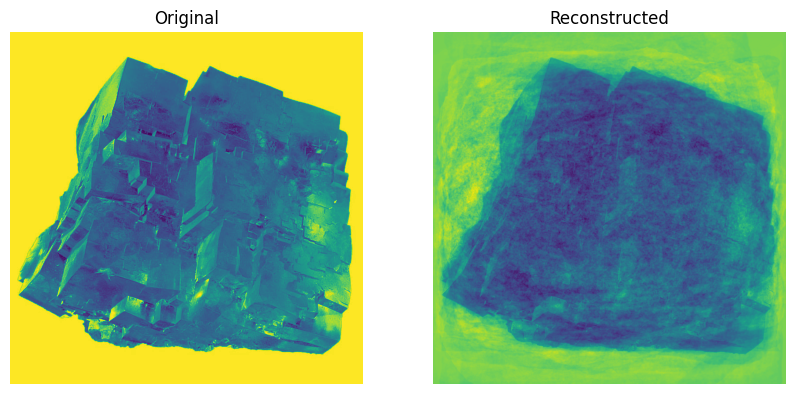

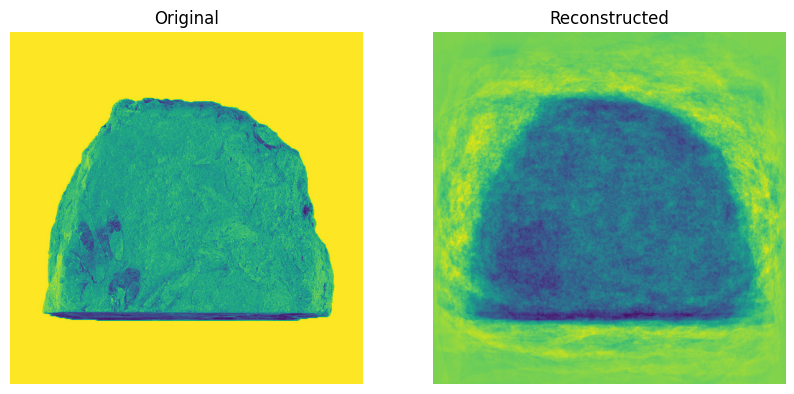

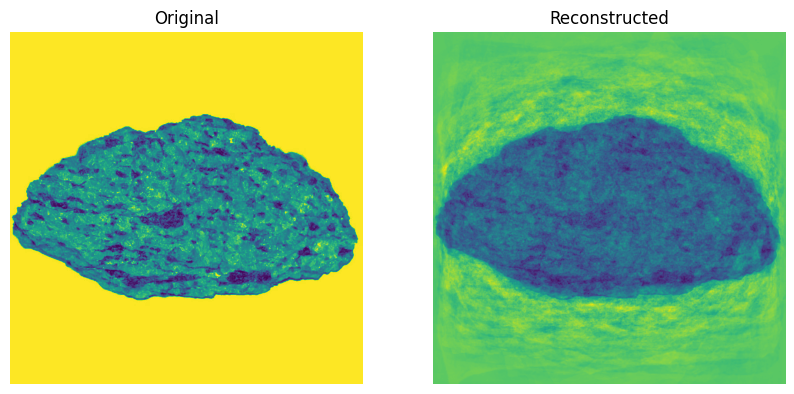

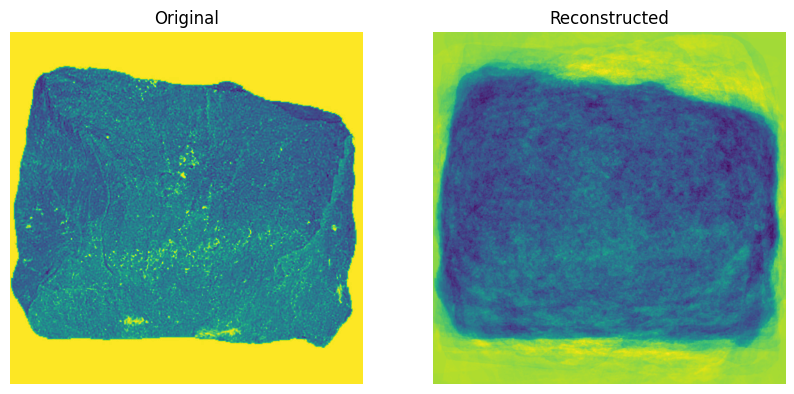

In [11]:
choice_image_index = np.random.choice([i for i in range(360)],10,replace=False)
print("Printing image indices: ", choice_image_index)

for image_index in choice_image_index:
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    image = imageog[image_index].reshape(800, 800)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')  
    plt.subplot(122)
    image = image_recovered[image_index].reshape(800, 800)
    plt.imshow(image)
    plt.title("Reconstructed")
    plt.axis('off')  
    plt.show()

Interesting! The reconstructed images are very much similar to the original ones!

***Question 3: PCA***

In [12]:
pca2 = PCA(n_components=2)
image_downsized2 = pca2.fit_transform(imageog)
image_recovered2 = pca2.inverse_transform(image_downsized2)

In [13]:
print("Variance explained by 2 dimensions: ",pca2.explained_variance_ratio_.sum())

Variance explained by 2 dimensions:  0.3318579476971998


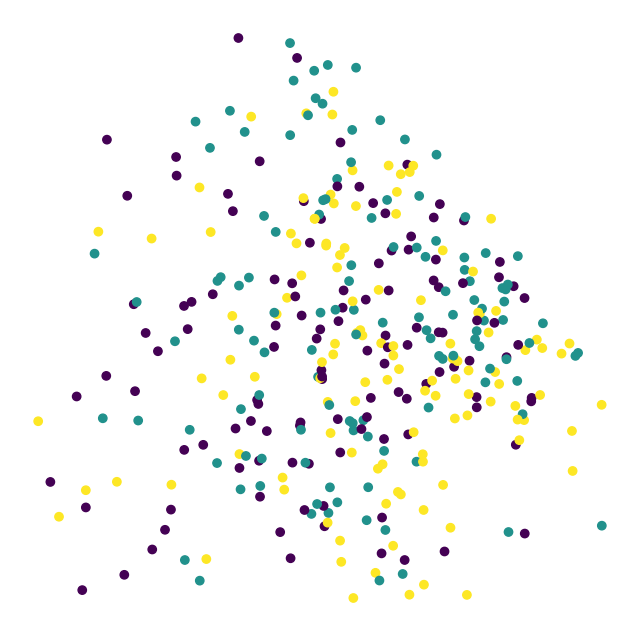

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(image_downsized2[:,0],image_downsized2[:,1], c = rock_type_integer)
plt.axis("off")
plt.show()

In [15]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.1, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 3)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 3),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(800, 800)
                imagebox = AnnotationBbox(OffsetImage(image, zoom=0.05),
                                          image_coord)
                ax.add_artist(imagebox)

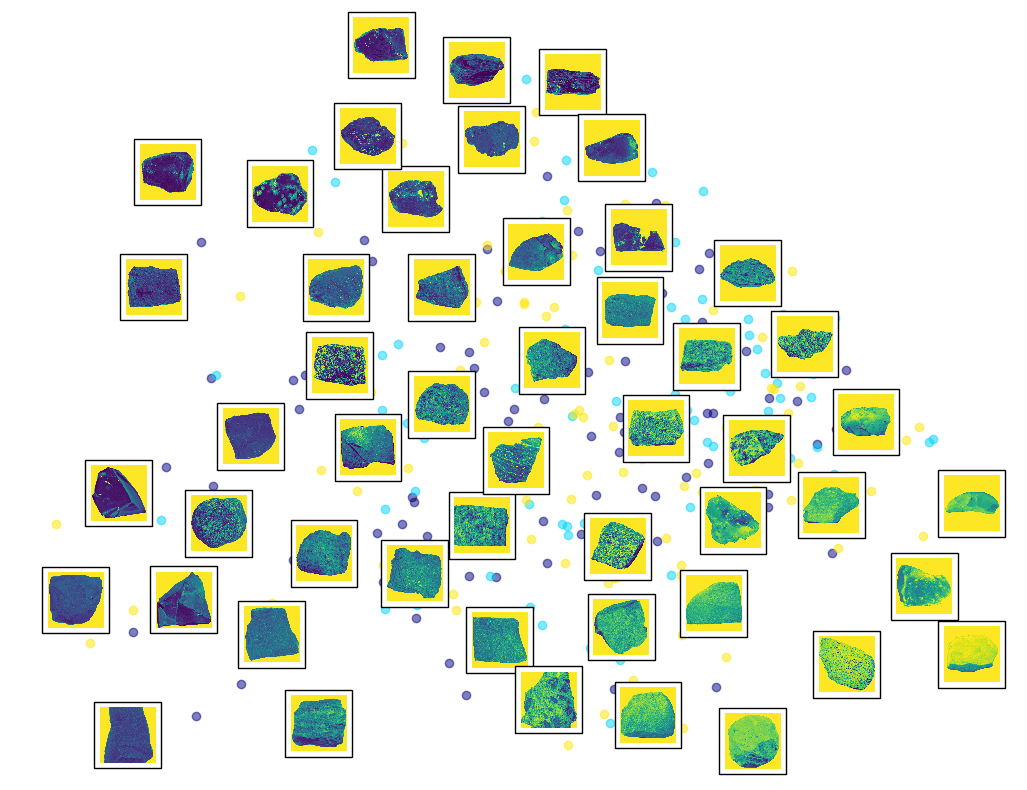

In [16]:

plot_digits(X = image_downsized2, y = rock_type_integer, images = imageog)

***Question 3: t-SNE***

***Question 3: LLE***

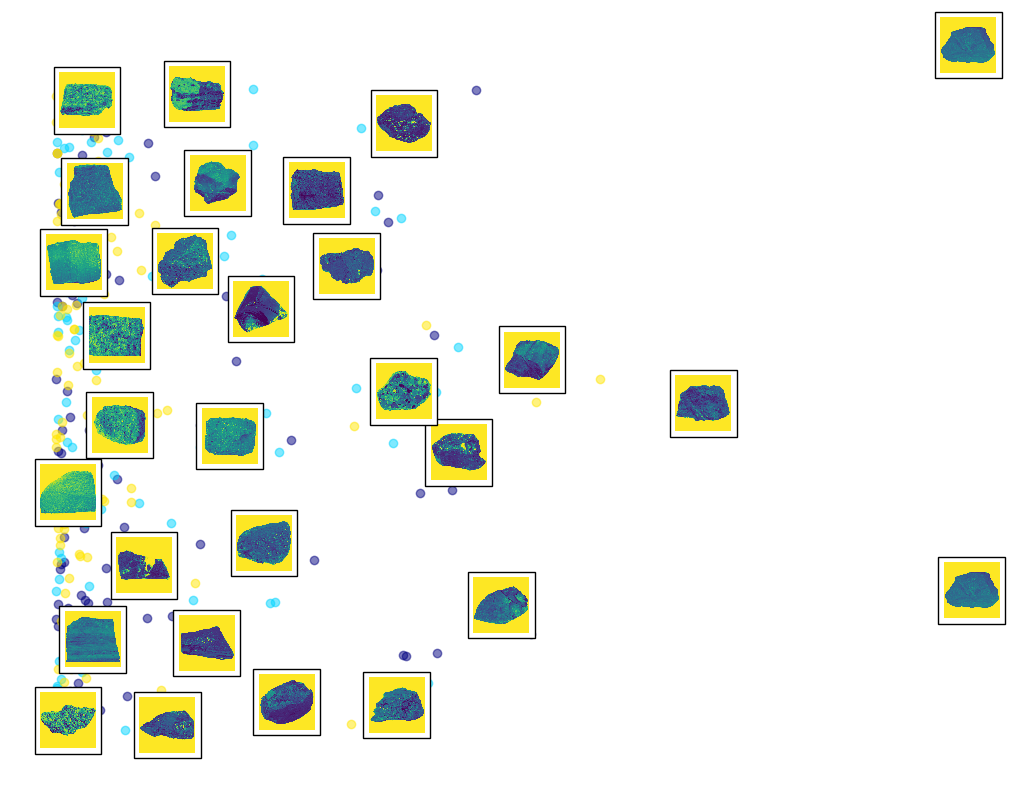

In [17]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=42)
images_lle_reduced = lle.fit_transform(imageog)
plot_digits(X = images_lle_reduced, y = rock_type_integer, images = imageog)
plt.show()

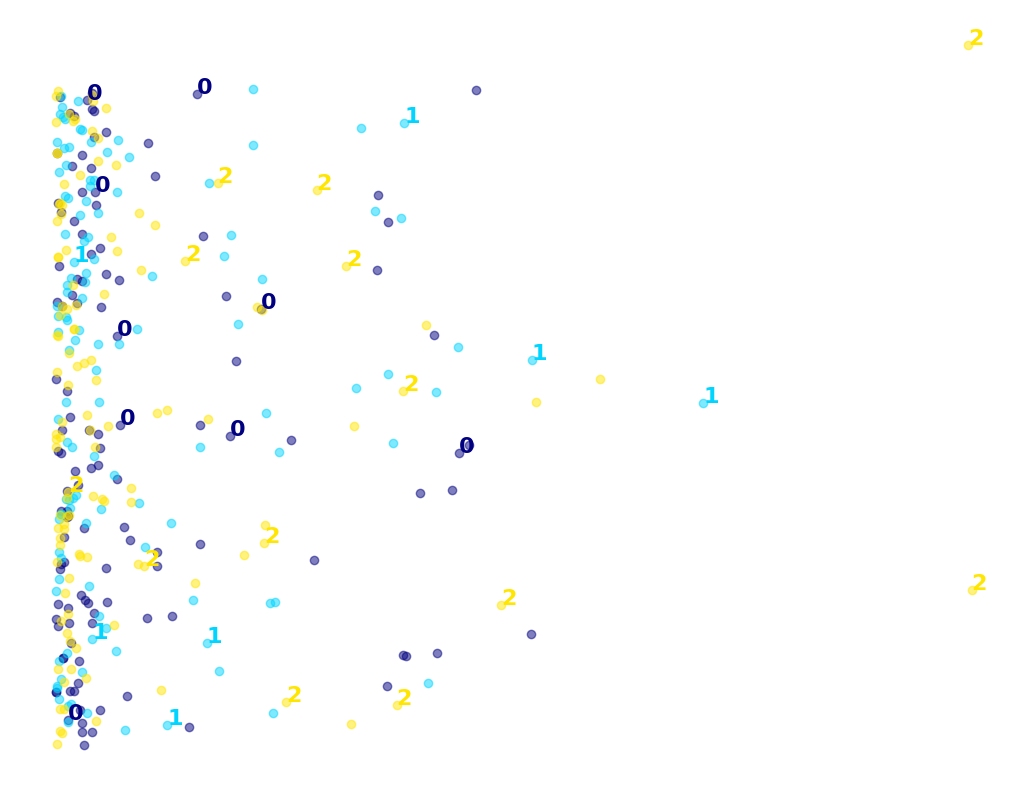

In [18]:
plot_digits(X = images_lle_reduced, y = rock_type_integer, images = None)
plt.show()

***Question 3: MDS***

***Question 4: PCA***

***Question 4: MDS***

***Question 4: LLE***

In [19]:
rocks_lle8 = LocallyLinearEmbedding(n_components=8, random_state=42)
reduced_lle8 = rocks_lle8.fit_transform(imageog)

In [20]:
import pandas as pd
human8 = np.array(pd.read_csv("Dataset/mds_360.txt", sep='\s+', header=None))

In [21]:
from scipy.spatial import procrustes
mtx1, mtx2, disparity = procrustes(human8, reduced_lle8)
print("Disparity with LLE: ", disparity )

Disparity with LLE:  0.9780151522429521


In [22]:
for i in range(8):
    print("Correlation in dimension "+str(i)+": ", np.corrcoef(mtx1[:,i],mtx2[:,i])[0][1])

Correlation in dimension 0:  0.16219771098562544
Correlation in dimension 1:  0.13017410798572043
Correlation in dimension 2:  0.13432882346158512
Correlation in dimension 3:  0.14916277827277646
Correlation in dimension 4:  0.15089459371358702
Correlation in dimension 5:  0.22721132389539694
Correlation in dimension 6:  0.08254765688531454
Correlation in dimension 7:  0.13564047168465648


***Question 5***

***Question 6***

In [25]:
from sklearn.mixture import GaussianMixture

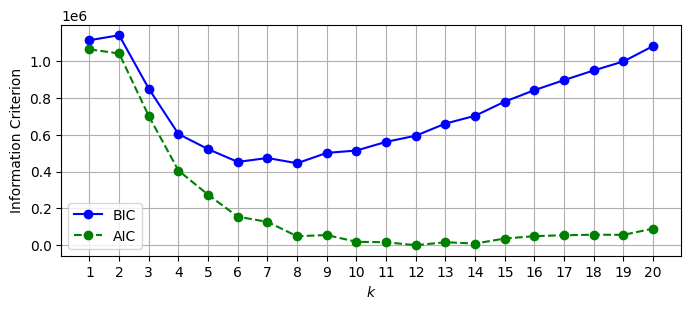

In [29]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(image_downsized)
             for k in range(1, 21)]
bics = [model.bic(image_downsized) for model in gms_per_k]
aics = [model.aic(image_downsized) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 21), bics, "bo-", label="BIC")
plt.plot(range(1, 21), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.xticks(range(1, 21),range(1, 21))
plt.legend()
plt.grid()
plt.show()

In [36]:
gm3 = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm3.fit(image_downsized)
predictions = gm3.predict(image_downsized)

In [43]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score


confusion_matrix = np.zeros((3, 3))
for true, pred in zip(rock_type_integer, predictions):
    confusion_matrix[true, pred] += 1

row_ind, col_ind = linear_sum_assignment(-confusion_matrix)

mapped_predictions = np.zeros_like(predictions)
for pred_label, true_label in zip(col_ind, row_ind):
    mapped_predictions[predictions == pred_label] = true_label

accuracy = accuracy_score(rock_type_integer, mapped_predictions)
print(f"Clustering Accuracy: {accuracy * 100:.2f}%")

Clustering Accuracy: 43.06%


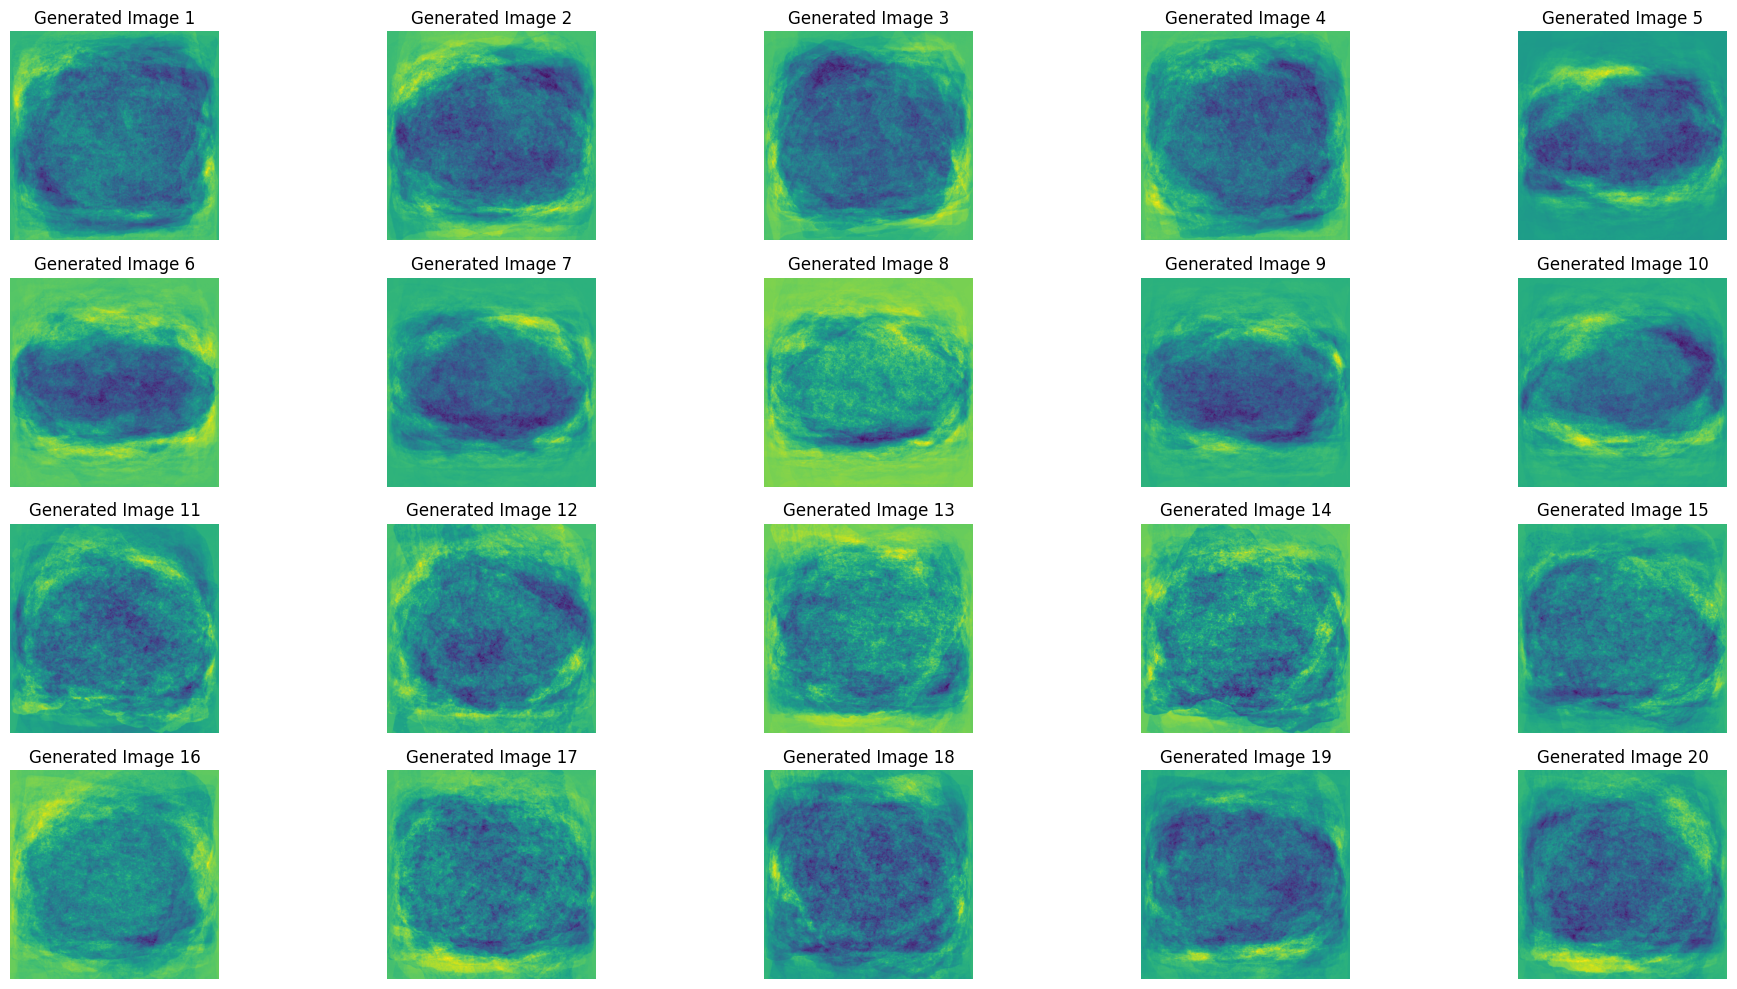

In [44]:

n_samples = 20
generated_samples, _ = gm3.sample(n_samples=n_samples)  

reconstructed_images = pca.inverse_transform(generated_samples)
reconstructed_images = reconstructed_images.reshape((n_samples, 800, 800))

plt.figure(figsize=(20, 10))
for i in range(n_samples):
    plt.subplot(4, 5, i + 1)  
    plt.imshow(reconstructed_images[i])
    plt.axis('off')
    plt.title(f"Generated Image {i+1}")

plt.tight_layout()
plt.show()


***Question 7***